In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from scipy import stats

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

In [4]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240224-103820_task_0/model_10000000.pt"
model = QNetwork(frame_stacks=1, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240224-103820_task_0/model_10000000.pt


In [5]:
concept = concept_instances['visible lava']
if concept.binary:
    concept_random = concept_instances['random binary']
else:
    concept_random = concept_instances['random continuous']
hyperparameters = {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 50, 'batch_size': 256}
TCAVs = []
TCAVs_random = []

In [6]:
def get_tcav_score(concept, env_steps):
    concept.prepare_data(env_steps, max_size=1000)
    probe, info = train_probes(model, concept, hyperparameters, [layer])
    # score = info[layer]['test_score'][-1]
    probe = probe[layer]

    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)

    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]

    # Additional forward pass to get gradients (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Initialize tensor to store results
    directional_derivatives = torch.zeros_like(q_values)

    # Compute directional derivatives
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        # Calculate directional derivative
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        directional_derivatives[:, j] = torch.mv(grads_flat, CAV)

    acts.grad.zero_()

    TCAV = sum(directional_derivatives > 0) / directional_derivatives.shape[0]
    return TCAV.cpu().numpy().mean()

In [7]:
for i in tqdm.tqdm(range(100)):
    TCAVs.append(get_tcav_score(concept, env_steps))
    TCAVs_random.append(get_tcav_score(concept_random, env_steps))

print(f'TCAV mean: {np.mean(TCAVs)}, std: {np.std(TCAVs)}')
print(f'TCAV random mean: {np.mean(TCAVs_random)}, std: {np.std(TCAVs_random)}')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

TCAV mean: 0.26276999711990356, std: 0.25341567397117615
TCAV random mean: 0.5297600030899048, std: 0.3535346984863281


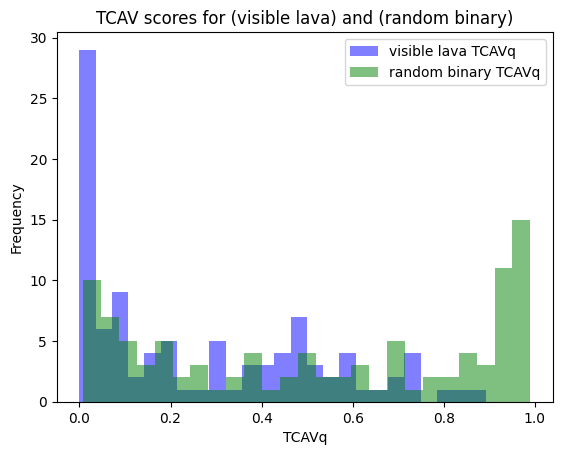

In [8]:
plt.hist(TCAVs, alpha=0.5, label=f'{concept.name} TCAVq', color='blue', bins=25)
plt.hist(TCAVs_random, alpha=0.5, label=f'{concept_random.name} TCAVq', color='green', bins=25)

# Adding labels and legend
plt.xlabel('TCAVq')
plt.ylabel('Frequency')
plt.title(f'TCAV scores for ({concept.name}) and ({concept_random.name})')
plt.legend()

plt.show()

In [9]:
result = stats.ttest_ind(TCAVs, TCAVs_random, equal_var=False)
print(f"t-statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

t-statistic: -6.107237536969532
p-value: 6.122895940754502e-09


### Relative CAV

In [10]:
concept1 = concept_instances['visible bullet']
concept2 = concept_instances['visible lava']

# Only use steps where either concept is present
filtered_steps = []
for step in env_steps:
    concept1_present = concept1.concept_function(step.state_variables)
    concept2_present = concept2.concept_function(step.state_variables)
    if (concept1_present or concept2_present) and concept1_present != concept2_present:
        filtered_steps.append(step)

concept_func = lambda x: concept1.concept_function(x)

concept_lava_vs_bullet = Concept('visible lava/bullet', binary=True, concept_function=concept_func)

In [11]:
get_tcav_score(concept_lava_vs_bullet, filtered_steps)

0.016999999